## Imports

In [75]:
import os
import numpy as np
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


In [76]:
def segment_spectrum(seg, fs, Nfft=65536):
    """Compute frequency axis and magnitude (dB) for a segment using a Hann window."""
    w = np.hanning(len(seg))
    X = np.fft.rfft(w * seg, n=Nfft)
    f = np.fft.rfftfreq(Nfft, 1/fs)
    mag_db = 20 * np.log10(np.abs(X) + 1e-12)
    return f, mag_db

In [77]:
# --- Utilities: shared helpers (extract_segments, pluck analysis) ---
def extract_segments(x, hit_times, fs, length=0.8, pre=0.01):
    """Extract segments of given length (seconds) around hit times."""
    segs = []
    pre_s = int(pre * fs)
    L = int(length * fs)
    for ht in hit_times:
        n0 = max(int(ht*fs) - pre_s, 0)
        n1 = min(n0 + L, len(x))
        segs.append(x[n0:n1])
    return segs

def analyse_pluck_correct(key, n_harmonics=8, f1_min=60.0, f1_max=150.0, Nfft=65536):
    """Estimate fundamental and harmonic peaks for a pluck recording in `audio[key]`.
    Returns: (f1, L1, harmonics, f_full, mag_full) where harmonics is list of (n, freq, level dB).
    """
    df = audio[key]
    x = df['x'].values
    fs = df.attrs['fs']
    # full FFT using shared segment_spectrum on the whole signal
    f_full, mag_full = segment_spectrum(x, fs, Nfft=Nfft)
    # find fundamental candidates in frequency band
    mask_f1 = (f_full >= f1_min) & (f_full <= f1_max)
    f_band = f_full[mask_f1]
    mag_band = mag_full[mask_f1]
    peaks_f1, _ = find_peaks(mag_band, height=np.max(mag_band)-40, distance=10)
    if len(peaks_f1) == 0:
        # fallback: use global minimum-frequency peak > f1_min
        peaks_f1, _ = find_peaks(mag_full, height=np.max(mag_full)-60)
        cand_mask = (f_full >= f1_min) & (f_full <= f1_max)
        peaks_f1 = [p for p in peaks_f1 if cand_mask[p]]
        if len(peaks_f1) == 0:
            raise RuntimeError(f'No fundamental candidates found for {key}')
    f_candidates = f_band[peaks_f1]
    L_candidates = mag_band[peaks_f1]

    # choose the strongest candidate in the band as f1
    idx_best = int(np.argmax(L_candidates))
    f1 = float(f_candidates[idx_best])
    L1 = float(L_candidates[idx_best])
    
    # find harmonic peaks up to 500 Hz
    mask_all = (f_full >= 20) & (f_full <= 500)
    f_low = f_full[mask_all]
    mag_low = mag_full[mask_all]
    peaks_all, _ = find_peaks(mag_low, height=np.max(mag_low)-60, distance=5)
    peak_freqs = f_low[peaks_all]
    peak_levels = mag_low[peaks_all]
    harmonics = []
    for n in range(1, n_harmonics+1):
        target = n * f1
        if len(peak_freqs)==0:
            harmonics.append((n, target, np.nan))
            continue
        idx_closest = int(np.argmin(np.abs(peak_freqs - target)))
        harmonics.append((n, float(peak_freqs[idx_closest]), float(peak_levels[idx_closest])))
    return f1, L1, harmonics, f_full, mag_full


## Data Loader

In [78]:

# "Generel data loader" – men for WAV i stedet for Excel
folder = r"C:\CATT\Assignment 1\Analysis\Files"

audio = {}  # svarer til df i dit Excel-eksempel

for fname in os.listdir(folder):
    if fname.lower().endswith(".wav"):
        path = os.path.join(folder, fname)
        
        # Læs wav
        x, fs = sf.read(path)   # x = samples, fs = samplerate
        
        # Stereo → mono (hvis nødvendigt)
        if x.ndim == 2:
            x = x.mean(axis=1)
        
        # Lav tidakse
        t = np.arange(len(x)) / fs
        
        # Brug filnavn uden .wav som nøgle (ligesom sheet_name)
        key = os.path.splitext(fname)[0]
        
        # Lav DataFrame med tid og signal
        df_sig = pd.DataFrame({
            "t": t,
            "x": x
        })
        # Gem samplerate som metadata
        df_sig.attrs["fs"] = fs
        
        audio[key] = df_sig

print(audio.keys())


dict_keys(['5 x Inside Guitar 1', '5 x inside guitar 2', '5 x udenpå 1.0', '5 x udenpå 2.0', 'Background', 'Plucking 1', 'Plucking 2', 'Plucking 3', 'Plucking 4', 'Plucking 5 1', 'Plucking 5 2'])


# Task 6

In [79]:
key_out1 = "5 x udenpå 1.0"
key_out2 = "5 x udenpå 2.0"

df_out1 = audio[key_out1]
df_out2 = audio[key_out2]

fs = df_out1.attrs["fs"]
x_out1 = df_out1["x"].values
x_out2 = df_out2["x"].values
t_out1 = df_out1["t"].values
t_out2 = df_out2["t"].values


In [81]:
min_gap_sec = 1.0
min_gap_samples = int(min_gap_sec * fs)

peaks1, _ = find_peaks(np.abs(x_out1),
                       distance=min_gap_samples,
                       height=np.max(np.abs(x_out1))*0.2)
hit_times_out1 = t_out1[peaks1]

peaks2, _ = find_peaks(np.abs(x_out2),
                       distance=min_gap_samples,
                       height=np.max(np.abs(x_out2))*0.2)
hit_times_out2 = t_out2[peaks2]

print("Outside hits 1:", hit_times_out1)
print("Outside hits 2:", hit_times_out2)



Outside hits 1: [3.124125   4.202      5.392125   6.62091667]
Outside hits 2: [2.32954167 3.637625   5.05277083 6.45708333 7.9764375 ]


In [ ]:
segments_out = []
segments_out += extract_segments(x_out1, hit_times_out1[-1:], fs)  
segments_out += extract_segments(x_out2, hit_times_out2[-1:], fs) 

print("Number of outside segments:", len(segments_out))


Number of outside segments: 2


In [ ]:
# Compute averaged spectrum for outside segments using shared `segment_spectrum`
all_mag_out = []
for seg in segments_out:
    f, mag = segment_spectrum(seg, fs)
    all_mag_out.append(mag)

all_mag_out = np.vstack(all_mag_out)
mean_mag_db_out = np.mean(all_mag_out, axis=0)


In [ ]:
df_bg = audio["Background"]
x_bg = df_bg["x"].values
f_bg, mag_bg = segment_spectrum(x_bg, fs)

noise_floor = np.percentile(mag_bg, 90)
signal_peak = np.max(mean_mag_db_out)

SNR = signal_peak - noise_floor
print("Estimated SNR ≈", SNR, "dB")


Estimated SNR ≈ 77.46892384596711 dB


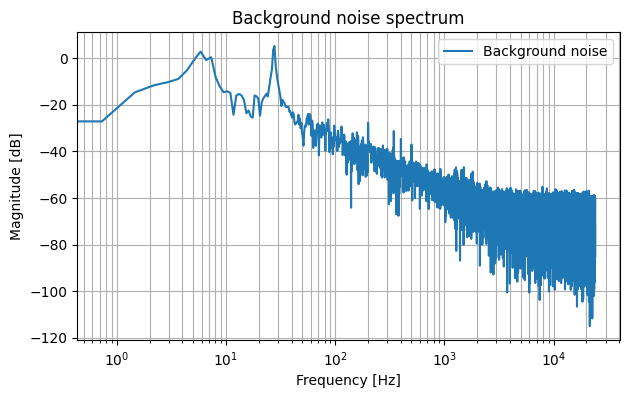

In [ ]:
# --- Load background noise (Task 6 step 1) ---
df_bg = audio["Background"]
x_bg = df_bg["x"].values
fs_bg = df_bg.attrs["fs"]

# --- Compute background spectrum ---
f_bg, mag_bg = segment_spectrum(x_bg, fs_bg)

plt.figure(figsize=(7,4))
plt.semilogx(f_bg, mag_bg, label="Background noise")
plt.title("Background noise spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.grid(True, which="both")
plt.legend()
plt.show()


In [ ]:
segments = []
segments += extract_segments(x_out1, hit_times_out1[-1:], fs)
segments += extract_segments(x_out2, hit_times_out2[-1:], fs)

print("Number of outside segments:", len(segments))

Number of outside segments: 2


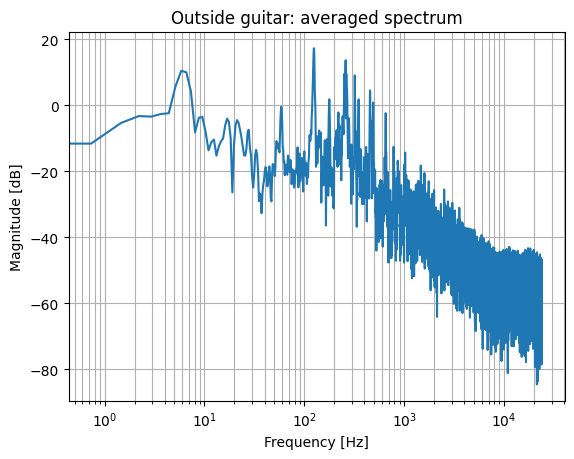

In [ ]:
all_mag = []
for seg in segments:
    f, mag_seg = segment_spectrum(seg, fs)
    all_mag.append(mag_seg)

mean_mag_db_out = np.mean(np.vstack(all_mag), axis=0)

plt.figure()
plt.semilogx(f, mean_mag_db_out)
plt.grid(True, which="both")
plt.title("Outside guitar: averaged spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.show()


In [ ]:
peaks, _ = find_peaks(mean_mag_db_out)

pf = f[peaks]
pm = mean_mag_db_out[peaks]

idx = np.argsort(pm)[-10:]
top_freqs_out = pf[idx]
top_mags_out  = pm[idx]

order = np.argsort(top_freqs_out)
top_freqs_out = top_freqs_out[order]
top_mags_out  = top_mags_out[order]

print("Task 6 – Top outside peaks:")
for fr, mag in zip(top_freqs_out, top_mags_out):
    print(f"{fr:8.1f} Hz  |  {mag:6.1f} dB")


Task 6 – Top outside peaks:
     5.9 Hz  |    10.5 dB
   124.5 Hz  |    17.3 dB
   178.0 Hz  |     1.8 dB
   252.7 Hz  |     9.6 dB
   259.3 Hz  |    13.6 dB
   263.7 Hz  |     9.5 dB
   267.3 Hz  |     4.7 dB
   320.1 Hz  |     9.1 dB
   349.4 Hz  |     1.8 dB
   455.6 Hz  |     4.5 dB


# Task 7

In [ ]:
key_in1 = "5 x Inside Guitar 1"
key_in2 = "5 x inside guitar 2"

df_in1 = audio[key_in1]
df_in2 = audio[key_in2]

fs = df_in1.attrs["fs"]


x_in1 = df_in1["x"].values
x_in2 = df_in2["x"].values
t_in1 = df_in1["t"].values
t_in2 = df_in2["t"].values

# --- Hit detection ---
peaks1, _ = find_peaks(np.abs(x_in1),
                       distance=int(fs*1.0),
                       height=np.max(np.abs(x_in1))*0.2)
hit_times_in1 = t_in1[peaks1]

peaks2, _ = find_peaks(np.abs(x_in2),
                       distance=int(fs*1.0),
                       height=np.max(np.abs(x_in2))*0.2)
hit_times_in2 = t_in2[peaks2]

#print("Inside hits 1:", hit_times_in1)
#print("Inside hits 2:", hit_times_in2)

Inside hits 1: [2.78608333 4.15016667 5.68870833 7.16477083 8.71297917]
Inside hits 2: [3.01710417 4.58135417 5.59472917]


In [ ]:

segments = []
segments += extract_segments(x_in1, [hit_times_in1[3]], fs)
segments += extract_segments(x_in2, hit_times_in2[-1:], fs)

print("Number of inside segments:", len(segments))


Number of inside segments: 2


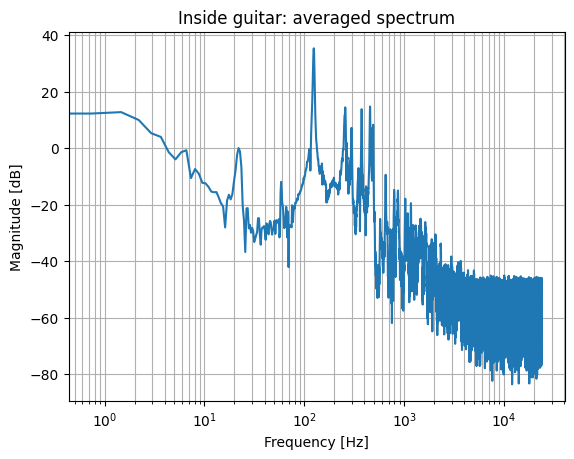

In [ ]:
all_mag = []
for seg in segments:
    f, mag_seg = segment_spectrum(seg, fs)
    all_mag.append(mag_seg)

mean_mag_db_in = np.mean(np.vstack(all_mag), axis=0)

plt.figure()
plt.semilogx(f, mean_mag_db_in)
plt.grid(True, which="both")
plt.title("Inside guitar: averaged spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.show()


In [ ]:
peaks, _ = find_peaks(mean_mag_db_in)

pf = f[peaks]
pm = mean_mag_db_in[peaks]

idx = np.argsort(pm)[-12:]
top_freqs_in = pf[idx]
top_mags_in  = pm[idx]

order = np.argsort(top_freqs_in)
top_freqs_in = top_freqs_in[order]
top_mags_in  = top_mags_in[order]

print("Task 7 – Inside resonances:")
for fr, mag in zip(top_freqs_in, top_mags_in):
    print(f"{fr:8.1f} Hz  |  {mag:7.2f} dB")


Task 7 – Inside resonances:
     1.5 Hz  |    12.71 dB
    22.0 Hz  |    -0.02 dB
   112.1 Hz  |    -0.43 dB
   124.5 Hz  |    35.30 dB
   253.4 Hz  |    11.50 dB
   257.1 Hz  |    14.38 dB
   265.1 Hz  |     1.90 dB
   297.4 Hz  |     7.14 dB
   375.0 Hz  |    13.76 dB
   455.6 Hz  |    14.70 dB
   461.4 Hz  |     7.12 dB
   489.3 Hz  |     8.23 dB


# Task 8

In [ ]:
f_cav = 253.4
L  = 0.65
mu = 3.5e-3

fund_freqs  = {}
fund_levels = {}

print("\n=== TASK 8 RESULTS ===")
for key in pluck_keys:
    f1, L1, harms, f, mag = analyse_pluck_correct(key)
    fund_freqs[key]  = f1
    fund_levels[key] = L1

    k_res = int(round(f_cav / f1))
    f_h = k_res * f1
    delta = f_h - f_cav

    print(f"\n{key}:")
    print(f"  f1 = {f1:.2f} Hz  (level = {L1:.2f} dB)")
    print(f"  Cavity harmonic: k = {k_res},  k*f1 = {f_h:.2f} Hz (Δ = {delta:.2f} Hz)")



=== TASK 8 RESULTS ===

Plucking 1:
  f1 = 87.16 Hz  (level = -25.69 dB)
  Cavity harmonic: k = 3,  k*f1 = 261.47 Hz (Δ = 8.07 Hz)

Plucking 2:
  f1 = 93.75 Hz  (level = -28.44 dB)
  Cavity harmonic: k = 3,  k*f1 = 281.25 Hz (Δ = 27.85 Hz)

Plucking 3:
  f1 = 68.85 Hz  (level = -27.25 dB)
  Cavity harmonic: k = 4,  k*f1 = 275.39 Hz (Δ = 21.99 Hz)

Plucking 4:
  f1 = 61.52 Hz  (level = -28.91 dB)
  Cavity harmonic: k = 4,  k*f1 = 246.09 Hz (Δ = -7.31 Hz)

Plucking 5 1:
  f1 = 100.34 Hz  (level = -26.07 dB)
  Cavity harmonic: k = 3,  k*f1 = 301.03 Hz (Δ = 47.63 Hz)


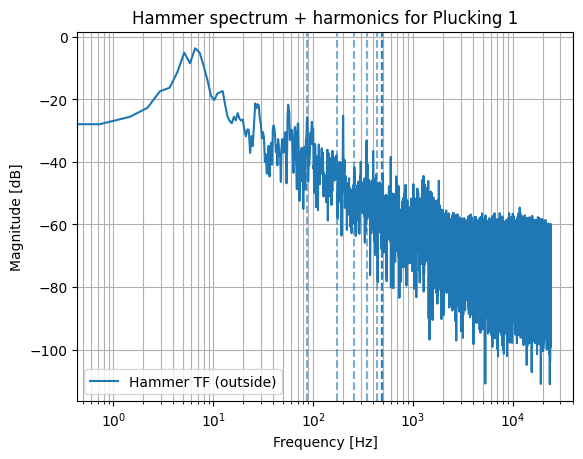

In [ ]:
key = "Plucking 1"
f1, L1, harmonics, f_tf, mag_tf = analyse_pluck_correct(key)

plt.figure()
plt.semilogx(f_tf, mag_tf, label="Plucking 1 – spectrum")
for (n, f_h, L_h) in harmonics:
    plt.axvline(f_h, linestyle="--", alpha=0.6)  
plt.title("Hammer spectrum + harmonics for Plucking 1")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.grid(True, which="both")
plt.legend()
plt.show()


# Task 9 

In [ ]:
def is_fundamental_strongest(harmonics):
    fund_level = None
    all_levels = []
    for (k, f, L) in harmonics:
        all_levels.append(L)
        if k == 1:
            fund_level = L
    return fund_level == max(all_levels)


In [ ]:
pluck_keys = ["Plucking 1", "Plucking 2", "Plucking 3", "Plucking 4", "Plucking 5 1"]

f_cav = 253.4     # Hz
mu = 3.5e-3       # kg/m
L  = 0.65         # m  <-- brug jeres målte L

fund_freqs   = {}
fund_levels  = {}
harmonic_hit = {}
harm_diff    = {}

for key in pluck_keys:
    f1, L1, harms, f, mag = analyse_pluck_correct(key)
    fund_freqs[key]  = f1
    fund_levels[key] = L1

  
    k_res = int(round(f_cav / f1))
    harmonic_hit[key] = k_res
    f_h = k_res * f1
    harm_diff[key] = f_h - f_cav

    print(f"\n{key}:")
    print(f"  f1 ≈ {f1:.2f} Hz, level ≈ {L1:.2f} dB")
    print(f"  k_res = {k_res}, k*f1 = {f_h:.2f} Hz (Δ ≈ {harm_diff[key]:.2f} Hz)")


# 9(b)
for key, L1 in fund_levels.items():
    print(f"{key}: fundamental level ≈ {L1:.2f} dB")


# 9(d)
f1_open = fund_freqs["Plucking 1"]
T = mu * (2 * L * f1_open)**2
print(f"\nEstimated string tension (corrected f1): T = {T:.2f} N")



Plucking 1:
  f1 ≈ 87.16 Hz, level ≈ -25.69 dB
  k_res = 3, k*f1 = 261.47 Hz (Δ ≈ 8.07 Hz)

Plucking 2:
  f1 ≈ 93.75 Hz, level ≈ -28.44 dB
  k_res = 3, k*f1 = 281.25 Hz (Δ ≈ 27.85 Hz)

Plucking 3:
  f1 ≈ 68.85 Hz, level ≈ -27.25 dB
  k_res = 4, k*f1 = 275.39 Hz (Δ ≈ 21.99 Hz)

Plucking 4:
  f1 ≈ 61.52 Hz, level ≈ -28.91 dB
  k_res = 4, k*f1 = 246.09 Hz (Δ ≈ -7.31 Hz)

Plucking 5 1:
  f1 ≈ 100.34 Hz, level ≈ -26.07 dB
  k_res = 3, k*f1 = 301.03 Hz (Δ ≈ 47.63 Hz)
Plucking 1: fundamental level ≈ -25.69 dB
Plucking 2: fundamental level ≈ -28.44 dB
Plucking 3: fundamental level ≈ -27.25 dB
Plucking 4: fundamental level ≈ -28.91 dB
Plucking 5 1: fundamental level ≈ -26.07 dB

Estimated string tension (corrected f1): T = 44.93 N
